#In this workbook you will
- Use RandomForest to calculate the best features for your model
- Handling outlying data using `apply` and `groupby`
- Discretize (or bucket) data into groups
- Make your own features for your model

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

In [2]:
df = pd.read_csv("./data/credit-data-trainingset.csv")

In [3]:
df.head()

,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
0,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
1,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
2,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
3,0,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0
4,0,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0


##Finding Important Features
We're going to let scikit-learn help us determine which variables are the best at predicting risk. To do this, we're going to use an algorithm called `RandomForest`. `RandomForest` randomly generates a "forest" of decision trees. As the trees are randomly generated, the algorithm takes turns leaving out each variable in fitting the model. This allows the `RandomForest` to calculate just how much worse a model does when each variable is left out.

In [58]:
from sklearn.ensemble import RandomForestClassifier

features = np.array(['revolving_utilization_of_unsecured_lines',
                     'age', 'number_of_time30-59_days_past_due_not_worse',
                     'debt_ratio', 'monthly_income','number_of_open_credit_lines_and_loans', 
                     'number_of_times90_days_late', 'number_real_estate_loans_or_lines',
                     'number_of_time60-89_days_past_due_not_worse', 'number_of_dependents'])

In [59]:
features

array(['revolving_utilization_of_unsecured_lines', 'age',
       'number_of_time30-59_days_past_due_not_worse', 'debt_ratio',
       'monthly_income', 'number_of_open_credit_lines_and_loans',
       'number_of_times90_days_late', 'number_real_estate_loans_or_lines',
       'number_of_time60-89_days_past_due_not_worse',
       'number_of_dependents'], dtype='<U43')

In [60]:
clf = RandomForestClassifier()
clf.fit(df[features], df['serious_dlqin2yrs'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
# from the calculated importances, order them from most to least important
# and make a barplot so we can visualize what is/isn't important
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

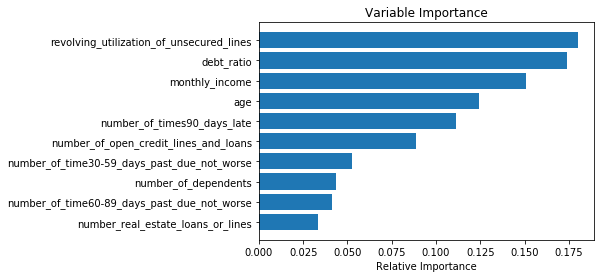

In [62]:
padding = np.arange(len(features)) + 0.5
pl.barh(padding, importances[sorted_idx], align='center')
pl.yticks(padding, features[sorted_idx])
pl.xlabel("Relative Importance")
pl.title("Variable Importance")
pl.show()

So you can see that the best variable is `revolving_utilization_of_unsecured_lines` while the worst is `number_real_estate_loans_or_lines`. There's also a dramatic drop off after `number_of_open_credit_lines_and_loans`. This is where you need to use your own discretion. How many variables should you include in your model?

###Engineering Additional Features
Feature selection/engineering will likely have the biggest impact in determining the success/failure of your model. Even if you're using the latest and greatest algorithm, if you put in non-important features you're going to get poor results. Remember, it's math, not magic.

Feature engineering is a skill that will take time to get the hang of. Sometimes the best way is to just talk to people. Ask questions, brainstorm with others, etc. Oftentimes 2 features might not be helpful when used individually, but when combined they can be extremely powerful.



In [63]:
df['income_bins'] = pd.cut(df.monthly_income, bins=15)
pd.value_counts(df['income_bins'])
# not very helpful

(4000.0, 5000.0]      15810
(3000.0, 4000.0]      14311
(6000.0, 7000.0]      13975
(5000.0, 6000.0]      12951
(2000.0, 3000.0]       9785
(7000.0, 8000.0]       9444
(8000.0, 9000.0]       7396
(1000.0, 2000.0]       5417
(9000.0, 10000.0]      5389
(14000.0, 15000.0]     5125
(-15.0, 1000.0]        3632
(10000.0, 11000.0]     3609
(11000.0, 12000.0]     2396
(12000.0, 13000.0]     1939
(13000.0, 14000.0]     1198
Name: income_bins, dtype: int64

###Bucketing Continuous Values

####Use the cap_value function you wrote previously to cap monthly_income at $15,000

In [64]:
def cap_values(x, cap):
    if x > cap:
        return cap
    else:
        return x
    
df.monthly_income = df.monthly_income.apply(lambda x: cap_values(x, 15000))

In [80]:
df.monthly_income.describe()

count    112377.000000
mean       6139.139682
std        3411.677509
min           0.000000
25%        3750.000000
50%        5528.375605
75%        7997.515360
max       15000.000000
Name: monthly_income, dtype: float64

In [81]:
df['income_bins'] = pd.cut(df.monthly_income, bins=15, labels=False)
pd.value_counts(df.income_bins)

4     15810
3     14311
6     13975
5     12951
2      9785
7      9444
8      7396
1      5417
9      5389
14     5125
0      3632
10     3609
11     2396
12     1939
13     1198
Name: income_bins, dtype: int64

In [67]:
df[["income_bins", "serious_dlqin2yrs"]].groupby("income_bins").mean()

,serious_dlqin2yrs
income_bins,
0,0.055341
1,0.102640
2,0.098212
3,0.094333
4,0.073498
5,0.066945
6,0.049660
7,0.050508
8,0.050568


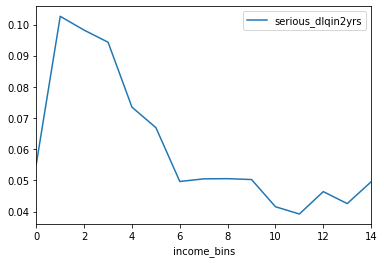

In [68]:
cols = ["income_bins", "serious_dlqin2yrs"]
df[cols].groupby("income_bins").mean().plot()

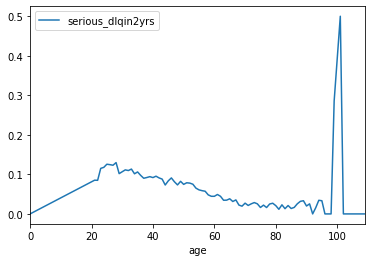

In [69]:
cols = ['age', 'serious_dlqin2yrs']
age_means = df[cols].groupby("age").mean()
age_means.plot()

####Bin `age` into 14 different groups. Then make a frequency table that shows the number of customers that were/were not delinquent for each bin.
*HINT: You might want to have larger bins near the min/max values to account for outliers.*

In [70]:
mybins =  range(20, 80, 5) 
df['age_bucket'] = pd.cut(df.age, bins=mybins)
df['age_bucket']

0         (35.0, 40.0]
1         (45.0, 50.0]
2         (70.0, 75.0]
3         (25.0, 30.0]
4         (50.0, 55.0]
              ...     
112372             NaN
112373    (25.0, 30.0]
112374             NaN
112375    (45.0, 50.0]
112376    (55.0, 60.0]
Name: age_bucket, Length: 112377, dtype: category
Categories (11, interval[int64]): [(20, 25] < (25, 30] < (30, 35] < (35, 40] ... (55, 60] < (60, 65] < (65, 70] < (70, 75]]

####Using the age bins, calculate the percent of customers that were delinquent for each bucket

In [71]:
df[["age_bucket", "serious_dlqin2yrs"]].groupby("age_bucket").mean()

,serious_dlqin2yrs
age_bucket,
"(20, 25]",0.112967
"(25, 30]",0.115932
"(30, 35]",0.108419
"(35, 40]",0.093133
"(40, 45]",0.086158
"(45, 50]",0.080508
"(50, 55]",0.071713
"(55, 60]",0.050849
"(60, 65]",0.040492


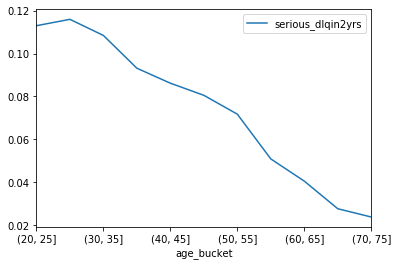

In [72]:
df[["age_bucket", "serious_dlqin2yrs"]].groupby("age_bucket").mean().plot()

In [73]:
labels, levels = pd.factorize(df.age_bucket)
df.age_bucket = labels

####Write something that buckets debt_ratio into 4 (nearly) equally sized groups.
*Hint: use the `quantile` method for Series*

In [82]:
bins = []

for q in [0.2, 0.4, 0.6, 0.8, 1.0]:
    bins.append(df.debt_ratio.quantile(q))

debt_ratio_binned = pd.cut(df.debt_ratio, bins=bins)
debt_ratio_binned
#print pd.value_counts(debt_ratio_binned)

0                       NaN
1                       NaN
2            (0.287, 0.466]
3            (0.287, 0.466]
4            (0.466, 3.659]
                ...        
112372    (3.659, 329664.0]
112373    (3.659, 329664.0]
112374    (3.659, 329664.0]
112375    (3.659, 329664.0]
112376    (3.659, 329664.0]
Name: debt_ratio, Length: 112377, dtype: category
Categories (4, interval[float64]): [(0.133, 0.287] < (0.287, 0.466] < (0.466, 3.659] < (3.659, 329664.0]]

###Scaling Features
Some algorithms will work better if your data is centered around 0. The `StandardScaler` module in `scikit-learn` makes it very easy to quickly scale columns in your data frame.

In [75]:
#from sklearn.preprocessing import StandardScaler
#df['monthly_income_scaled'] = StandardScaler().fit_transform(df.monthly_income)
from sklearn.preprocessing import scale
df['monthly_income_scaled'] = pd.DataFrame(scale(df.monthly_income, axis=0, with_mean=True, with_std=True, copy=True))

In [76]:
df.monthly_income_scaled.describe()

count    1.123770e+05
mean     1.484002e-16
std      1.000004e+00
min     -1.799457e+00
25%     -7.002861e-01
50%     -1.790224e-01
75%      5.447127e-01
max      2.597227e+00
Name: monthly_income_scaled, dtype: float64

Mean at 0? True


(array([ 5323., 12220., 21448., 21457., 20252., 11444.,  7366.,  4199.,
         2876.,  5792.]),
 array([-1.79945701, -1.35978864, -0.92012028, -0.48045191, -0.04078354,
         0.39888482,  0.83855319,  1.27822155,  1.71788992,  2.15755828,
         2.59722665]),
 <a list of 10 Patch objects>)

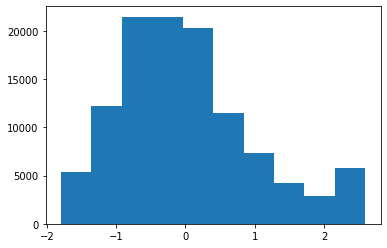

In [77]:
df.monthly_income_scaled.describe()
print("Mean at 0?", round(df.monthly_income_scaled.mean(), 10)==0)

df['monthly_income_scaled']
pl.hist(df.monthly_income_scaled)

##Redo our feature importance

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


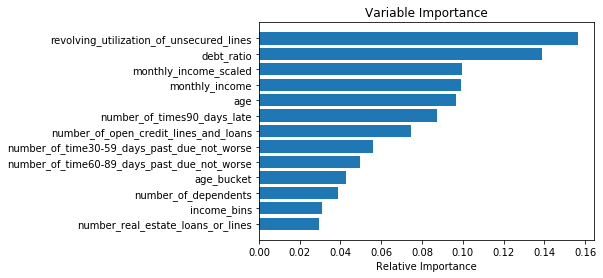

In [78]:
features = np.array(['revolving_utilization_of_unsecured_lines',
                     'age', 'number_of_time30-59_days_past_due_not_worse',
                     'debt_ratio', 'monthly_income','number_of_open_credit_lines_and_loans', 
                     'number_of_times90_days_late', 'number_real_estate_loans_or_lines',
                     'number_of_time60-89_days_past_due_not_worse', 'number_of_dependents',
                     'income_bins', 'age_bucket', 'monthly_income_scaled'])

clf = RandomForestClassifier()
clf.fit(df[features], df['serious_dlqin2yrs'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features)) + 0.5
pl.barh(padding, importances[sorted_idx], align='center')
pl.yticks(padding, features[sorted_idx])
pl.xlabel("Relative Importance")
pl.title("Variable Importance")
pl.show()

In [79]:
best_features = features[sorted_idx][::-1]
best_features

array(['revolving_utilization_of_unsecured_lines', 'debt_ratio',
       'monthly_income_scaled', 'monthly_income', 'age',
       'number_of_times90_days_late',
       'number_of_open_credit_lines_and_loans',
       'number_of_time30-59_days_past_due_not_worse',
       'number_of_time60-89_days_past_due_not_worse', 'age_bucket',
       'number_of_dependents', 'income_bins',
       'number_real_estate_loans_or_lines'], dtype='<U43')

##Test out your own features
Partner with the person sitting next to you and see if you can come up with some new features that outperform the basic variables.

- brainstorm new features
- create them using pandas
- test their effectiveness w/ scikit-learn

Things you might try:

- Try using some of the scikit-learn [preprecessing functions](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- Look at `pd.get_dummies`
- Combine features together (total times late, log(monthly_income), age^2)

##We just did the following

- Ranked feature importance using RandomForest
- Created some of our own features using `pandas` and `scikit-learn`
- Scaled data using `scikit-learn`